- CURRENT_PATH : 가장 상위 폴더를 지정하면 됩니다.

In [2]:
import os
CURRENT_PATH = os.getcwd()

- 라이브러리 import 및 옵션 설정

In [3]:
# 데이터 처리 관련 라이브러리
import pandas as pd
import numpy as np

from IPython.display import display
from tqdm import tqdm

# 날짜 변수 관련 라이브러리
import re
from datetime import date
from datetime import datetime
from datetime import timedelta

# plot 관련 라이브러리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline

# Modeling 관련 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
from xgboost import plot_importance

# Error 관련 라이브러리
import until

# 데이터프레임에서 실수값 표시 옵션
pd.options.display.float_format = '{:.2f}'.format
# pd.reset_option('display.float_format')

# plot에 한글 폰트 지정
fm.get_fontconfig_fonts()
font_path = CURRENT_PATH + '\\NanumSquareR.ttf'

# 1. 전처리

## 0) data read

In [4]:
df_consumer = pd.read_csv( CURRENT_PATH + "\\'21년 해카톤_고객정보.csv", encoding = 'cp949')
df_car = pd.read_csv( CURRENT_PATH + "\\new_해카톤_차량정보.csv", encoding = 'cp949')
df_contact = pd.read_csv( CURRENT_PATH + "\\'21년 해카톤_접촉정보.csv", encoding = 'cp949')

## 1) 고객정보.csv

- 개인사업자 여부(PSN_BIZR_YN) : 결측치를 모두 'N'으로 수정

In [5]:
df_consumer.PSN_BIZR_YN.replace(to_replace = np.nan, value = 'N', inplace = True)

- 생년월(TYMD)
  - 오류 데이터 결측치 처리 및 제거, 차량정보에서도 해당 고객 제거
  - date 타입으로 형 변환

In [6]:
tmp = df_consumer.loc[df_consumer.TYMD > 20640000, 'CUS_ID']
df_consumer = df_consumer.loc[df_consumer.TYMD < 20640000]
df_consumer.reset_index(drop = True, inplace = True)

df_car = df_car.loc[ df_car.CUS_ID.isin(tmp) == False ]
df_car.reset_index(drop = True, inplace = True)

In [7]:
def from_num_to_datetime(x): # 숫자를 date 타입으로 형 변환하는 함수
    x = int(x)
    y, m, d = x // 10000, (x//100) % 100, x % 100
    return date(year = y, month = m, day = max(d, 1))
df_consumer.loc[df_consumer.TYMD.notnull(), 'TYMD'] = df_consumer.loc[df_consumer.TYMD.notnull(), 'TYMD'].map(from_num_to_datetime)

## 2) 차량정보.csv

- 고객ID, 출고일자에 맞춰 정렬

In [8]:
df_car.sort_values(['CUS_ID', 'WHOT_DT'], inplace = True)
df_car.reset_index(drop = True, inplace = True)

- 출고일자, 보유시작일자, 보유종료일자 모두 date 타입으로 형 변환

In [9]:
df_car.WHOT_DT = [date(x1, x2, x3) for x1, x2, x3 in df_car.WHOT_DT.map(lambda x: map(int, x.split('-')))]
df_car.CAR_HLDG_STRT_DT = [date(x1, x2, x3) for x1, x2, x3 in df_car.CAR_HLDG_STRT_DT.map(lambda x: map(int, x.split('-')))]
df_car.loc[df_car.CAR_HLDG_FNH_DT.notnull(), 'CAR_HLDG_FNH_DT'] = [date(x1, x2, x3) for x1, x2, x3 in df_car.loc[df_car.CAR_HLDG_FNH_DT.notnull(), 'CAR_HLDG_FNH_DT'].map(lambda x: map(int, x.split('-')))]

# 2. 샘플링

## 1) 고객정보.csv - 파생변수 생성
- 차후에 차량정보를 기간에 맞춰 분리하는데 이 때, 기간에 영향받지 않는 고객정보 관련 파생변수를 생성합니다.

- 주소_행정시도명 기재여부 : ADM_YN

In [10]:
df_consumer['ADM_YN'] = 1
df_consumer.loc[df_consumer.CUS_ADM_TRY_NM.isnull(), 'ADM_YN'] = 0

- 주택 평형 기재여부 : PYG_YN
- 주택 평수 : PYN_NUM

In [11]:
df_consumer['PYG_YN'] = 1
df_consumer.loc[df_consumer.CLB_HOUS_PYG_NM.isnull(), 'PYG_YN'] = 0

In [12]:
df_consumer['PYG_NUM'] = 0 # 평형을 기재하지 않을 경우 0값으로 대체
p = re.compile(r'([ \d]+)(.*)') # 첫 번째 그룹 : 평수, 두 번째 그룹 : 옵션
tmp = [p.findall(x)[0] for x in df_consumer.CLB_HOUS_PYG_NM[df_consumer.CLB_HOUS_PYG_NM.notnull()].values ]
df_consumer.loc[df_consumer.CLB_HOUS_PYG_NM.notnull(), 'PYG_NUM'] = list(map(lambda x: int(x[0]), tmp))

- 주택 평균가격 기재여부 : REAI_BZTC_YN

In [13]:
df_consumer['REAI_BZTC_YN'] = 1
df_consumer.loc[df_consumer.REAI_BZTC_AVG_PCE.isnull(), 'REAI_BZTC_YN'] = 0

- 최초구매나이 : FIRST_BUY_AGE

In [14]:
tmp = df_car.loc[(df_car.CUS_CAR_SCTN == 1) & (df_car.NUM_IN_SECTION == 1),['CUS_ID','WHOT_DT']] # 최초구매한 관측치만 모은 데이터
df_consumer = pd.merge(df_consumer, tmp, on = 'CUS_ID')
df_consumer['FIRST_BUY_AGE'] = (df_consumer.WHOT_DT - df_consumer.TYMD).map(lambda x: x.days).values // 365.25
df_consumer.drop('WHOT_DT', 1, inplace = True)

## 2) 차량정보.csv 데이터 분리 함수
- 6개월간의 특정기간을 예측하기 위해 예측 변수를 생성할 차량정보 데이터와 종속변수를 생성할 차량정보 데이터로 분리합니다.
- 예측 변수를 생성할 차량정보 데이터에서 6개월 특정기간에 포함되는 보유종료일자는 예측할 시점에서는 알 수 없는 자료이므로 결측치 처리를 합니다.
- sampling_XY : '예측변수를 생성할 차량정보데이터'와 '6개월 내 대차가 이루어진 고객 ID array' 를 튜플로 리턴합니다.

In [15]:
def sampling_XY( Y_period_s, Y_period_e):
    For_X = df_car.loc[df_car.WHOT_DT < Y_period_s].copy() # Y값 산출 기간보다 더 빠른 출고일자들은 모두 X값 산출을 위한 데이터
    For_X.loc[(Y_period_s <= df_car.CAR_HLDG_FNH_DT), 'CAR_HLDG_FNH_DT'] = np.nan #  Y값 산출 기간보다 더 늦은 보유종료일자는 결측치 처리
    
    For_Y = df_car.loc[(Y_period_s <= df_car.WHOT_DT) & (df_car.WHOT_DT <= Y_period_e)].copy() # Y값 산출 기간에 해당하는 데이터
    For_Y = np.unique( For_Y.loc[For_Y.REPURCHASE_TYPE == 0, 'CUS_ID'] ) # 6개월 내 '대차'인 CUS_ID 생성
    return (For_X, For_Y)

## 3) 파생변수 생성 과정 (test set)
- 파생변수 생성과정을 함수처럼 사용할 예정이지만 자세한 사항들을 구분해서 보여주기 위해 test set에 대해 진행합니다.
- test set은 2017년 하반기(2017.07.01 ~ 2017.12.31)를 예측할 데이터입니다.
- 예측할 6개월 특정기간의 시작날짜와 마지막날짜를 각각 Y_period_s, Y_period_e 변수에 지정합니다.
- 데이터 분리 함수를 통하여 차량정보 데이터를 분리합니다.

In [16]:
Y_period_s, Y_period_e = date(2017,7,1), date(2017,12,31)
For_X, For_Y = sampling_XY( Y_period_s, Y_period_e ) # 차량정보 데이터 분리

### (1) 고객 관련 파생변수 생성

In [17]:
tmp_df_consumer = df_consumer.copy() # 임시 고객 데이터 생성

- 현재 나이 : CURRENT_AGE (예측 변수를 생성할 기간 기준)

In [18]:
tmp_df_consumer['CURRENT_AGE'] = (Y_period_s - tmp_df_consumer.TYMD).map(lambda x: x.days).values // 365.25

- 가장 마지막 보유일자 : LAST_FNH
  - 한 고객의 보유종료일자 중 결측치를 제외한 가장 오래된 값입니다.
  - 만약 모든 보유종료일자가 결측치인 경우 2099/01/01로 지정합니다.

In [19]:
tmp_cus, tmp_last = [], []
for i, j in tqdm(For_X.groupby('CUS_ID').CAR_HLDG_FNH_DT):
    tmp_cus.append(i)
    if all( j.isnull() ):
        tmp_last.append( date(2099,1,1) )
    else:
        tmp_last.append( max(j[j.notnull()]) )

tmp_df_consumer = pd.merge(tmp_df_consumer, pd.DataFrame( {'CUS_ID' : tmp_cus, 'LAST_FNH' : tmp_last} ), on = 'CUS_ID')
del tmp_cus, tmp_last

100%|██████████████████████████████████████████████████████████████████████| 1078831/1078831 [03:42<00:00, 4841.03it/s]


- 가장 마지막 보유일자 나이 : LAST_FNH_AGE ( 가장 마지막 보유일자 기준)
  - 만약 마지막 보유일자가 2099/01/01인 경우 현재 나이로 대체합니다.

In [20]:
tmp_df_consumer['LAST_FNH_AGE'] = tmp_df_consumer['CURRENT_AGE']
a = date(2099,1,1)
tmp = tmp_df_consumer.loc[tmp_df_consumer.LAST_FNH != a]
tmp_df_consumer.loc[tmp_df_consumer.LAST_FNH != a, 'LAST_FNH_AGE'] = (tmp.LAST_FNH - tmp.TYMD).map(lambda x: x.days).values // 365.25

### (2) 구매, 보유기간 관련 파생변수 생성

- 차량보유기간 : CAR_HAVE_PERIOD 
  - 차량보유기간 = 보유종료일자 - 출고일자 (단위 : 개월수)

In [21]:
tmp = (For_X.CAR_HLDG_FNH_DT - For_X.WHOT_DT).map(lambda x: x.days).values
tmp_minus_idx = tmp < 0
tmp = abs(tmp)
tmp = (tmp // 365) * 12 + (tmp % 365) // 30 + 1
tmp[tmp_minus_idx] = - tmp[tmp_minus_idx]

For_X['CAR_HAVE_PERIOD'] = tmp
del tmp_minus_idx

C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in floor_divide
  after removing the cwd from sys.path.
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in remainder
  after removing the cwd from sys.path.


- 보유종료값 존재여부 : FNH_YN
  - 앞서 만든 가장 마지막 보유일자(LAST_FNH)가 2099/01/01인지 여부로 생성했습니다.

In [22]:
tmp_df_consumer['FNH_YN'] = 1
a = date(2099,1,1)
tmp_df_consumer.loc[tmp_df_consumer.LAST_FNH == a,'FNH_YN'] = 0

- 평균/최대/최소 차량 보유기간 : MEAN/MAX/MIN_HAVE_PERIOD

In [23]:
tmp = For_X.groupby('CUS_ID').CAR_HAVE_PERIOD.agg(['mean',max,min]).reset_index(drop = False)
tmp.columns = ['CUS_ID','MEAN_HAVE_PERIOD','MAX_HAVE_PERIOD','MIN_HAVE_PERIOD']
tmp.replace(np.nan, 0, inplace = True)
tmp_df_consumer = pd.merge(tmp_df_consumer, tmp, on = 'CUS_ID')

- 가장 마지막 보유일자와 현재까지 기간 : LAST_FNH_CUR_PERIOD
  - Y_period_s - 마지막 보유종료일자 (단위 : 개월수)
  - 보유일자가 모두 결측치일 경우 0을 지정했습니다.

In [24]:
tmp_df_consumer.LAST_FNH.replace(date(2099,1,1), np.nan, inplace = True)

tmp = (Y_period_s - tmp_df_consumer.LAST_FNH).map(lambda x: x.days).values
tmp = (tmp // 365) * 12 + (tmp % 365) // 30 + 1

tmp_df_consumer['LAST_FNH_CUR_PERIOD'] = tmp
tmp_df_consumer.LAST_FNH_CUR_PERIOD.replace(np.nan, 0, inplace = True)
tmp_df_consumer.LAST_FNH.replace(np.nan, date(2099,1,1), inplace = True)

C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in floor_divide
  after removing the cwd from sys.path.
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in remainder
  after removing the cwd from sys.path.


- 가장 마지막 출고일자와 현재까지 기간 : LAST_WHOT_CUR_PERIOD
  - Y_period_s - 마지막 출고일자 (단위 : 개월수)

In [25]:
tmp = For_X.groupby('CUS_ID').WHOT_DT.agg(max).reset_index(drop = False)
tmp_df_consumer = pd.merge(tmp_df_consumer, tmp, on = 'CUS_ID')

tmp1 = (Y_period_s - tmp_df_consumer.WHOT_DT).map(lambda x: x.days).values
tmp1 = (tmp1 // 365) * 12 + (tmp1 % 365) // 30 + 1

tmp_df_consumer['LAST_WHOT_CUR_PERIOD'] = tmp1
tmp_df_consumer.drop('WHOT_DT', 1, inplace = True)

### (3) 차량 대수 관련

- 현재 가지고 있는 차량수 : CUR_CAR_NUM
- 최대 운용했던 차량수 : MAX_CAR_NUM
- 구매 횟수 : BUY_NUM
- 섹션 내 최대 구매횟수 : MAX_NUM_IN_SCTN

In [26]:
tmp = For_X.groupby('CUS_ID').agg({'CAR_HLDG_FNH_DT' : ( lambda x: sum(x.isnull()) ), 'CUS_CAR_SCTN' : max, 'CAR_ID' : len, 'NUM_IN_SECTION' : max})
tmp = tmp.reset_index()
tmp.columns = ['CUS_ID', 'CUR_CAR_NUM', 'MAX_CAR_NUM', 'BUY_NUM', 'MAX_NUM_IN_SCTN']

tmp_df_consumer = pd.merge(tmp_df_consumer, tmp, on = 'CUS_ID')

### (4) 종속변수 생성 : Y (대차여부)

In [27]:
tmp_df_consumer['Y'] = 0
tmp_df_consumer.loc[tmp_df_consumer.CUS_ID.isin( For_Y ), 'Y'] = 1

In [28]:
test_set = tmp_df_consumer.copy()
del tmp_df_consumer

## 4) 파생변수 생성함수 (train set)
- 앞서 진행한 과정을 하나의 함수로 만들어 train set을 생성합니다.
- train set은 각 연도별 상반기, 하반기를 예측할 데이터를 모아 만듭니다. (Data Agumentation)
- 즉, 2010년 상반기 예측할 데이터부터 2017년 상반기를 예측할 데이터를 쌓습니다.

In [29]:
Y_period_s_list = [date(y,m,1) for y in range(2010,2018) for m in [1,7]]
Y_period_s_list = Y_period_s_list[:-1]

Y_period_e_list = [date(y,m,d) for y in range(2010,2018) for m,d in zip([6,12],[30,31])]
Y_period_e_list = Y_period_e_list[:-1]

In [30]:
def Sampling_Modify( Y_period_s , Y_period_e):
    For_X, For_Y = sampling_XY( Y_period_s, Y_period_e ) # 차량정보 데이터 분리

    tmp_df_consumer = df_consumer.copy() # 임시 고객 데이터 생성

    # 1. 현재 나이 : CURRENT_AGE
    tmp_df_consumer['CURRENT_AGE'] = (Y_period_s - tmp_df_consumer.TYMD).map(lambda x: x.days).values // 365.25

    # 2. 가장 마지막 보유일자 : LAST_FNH
    tmp_cus, tmp_last = [], []
    for i, j in tqdm(For_X.groupby('CUS_ID').CAR_HLDG_FNH_DT):
        tmp_cus.append(i)
        if all( j.isnull() ):
            tmp_last.append( date(2099,1,1) )
        else:
            tmp_last.append( max(j[j.notnull()]) )
    tmp_df_consumer = pd.merge(tmp_df_consumer, pd.DataFrame( {'CUS_ID' : tmp_cus, 'LAST_FNH' : tmp_last} ), on = 'CUS_ID')

    # 3. 가장 마지막 보유일자 나이 : LAST_FNH_AGE
    tmp_df_consumer['LAST_FNH_AGE'] = tmp_df_consumer['CURRENT_AGE']
    a = date(2099,1,1)
    tmp = tmp_df_consumer.loc[tmp_df_consumer.LAST_FNH != a]
    tmp_df_consumer.loc[tmp_df_consumer.LAST_FNH != a, 'LAST_FNH_AGE'] = (tmp.LAST_FNH - tmp.TYMD).map(lambda x: x.days).values // 365.25

    # 4. 차량보유기간 : CAR_HAVE_PERIOD
    tmp = (For_X.CAR_HLDG_FNH_DT - For_X.WHOT_DT).map(lambda x: x.days).values
    tmp_minus_idx = tmp < 0
    tmp = abs(tmp)
    tmp = (tmp // 365) * 12 + (tmp % 365) // 30 + 1
    tmp[tmp_minus_idx] = - tmp[tmp_minus_idx]
    For_X['CAR_HAVE_PERIOD'] = tmp

    # 5. 보유종료값 존재여부 : FNH_YN
    tmp_df_consumer['FNH_YN'] = 1
    tmp_df_consumer.loc[tmp_df_consumer.LAST_FNH == date(2099,1,1),'FNH_YN'] = 0

    # 6. 평균/최대/최소 차량 보유기간 : MEAN/MAX/MIN_HAVE_PERIOD
    tmp = For_X.groupby('CUS_ID').CAR_HAVE_PERIOD.agg(['mean',max,min]).reset_index(drop = False)
    tmp.columns = ['CUS_ID','MEAN_HAVE_PERIOD','MAX_HAVE_PERIOD','MIN_HAVE_PERIOD']
    tmp.replace(np.nan, 0, inplace = True)
    tmp_df_consumer = pd.merge(tmp_df_consumer, tmp, on = 'CUS_ID')

    # 7. 가장 마지막 보유일자와 현재까지 기간(LAST_FNH_CUR_PERIOD) - 단위 : 개월수
    tmp_df_consumer.LAST_FNH.replace(date(2099,1,1), np.nan, inplace = True)
    tmp = (Y_period_s - tmp_df_consumer.LAST_FNH).map(lambda x: x.days).values
    tmp = (tmp // 365) * 12 + (tmp % 365) // 30 + 1
    tmp_df_consumer['LAST_FNH_CUR_PERIOD'] = tmp
    tmp_df_consumer.LAST_FNH_CUR_PERIOD.replace(np.nan, 0, inplace = True)
    tmp_df_consumer.LAST_FNH.replace(np.nan, date(2099,1,1), inplace = True)

    # 8. 가장 마지막 출고일자와 현재까지 기간(LAST_WHOT_CUR_PERIOD)
    tmp = For_X.groupby('CUS_ID').WHOT_DT.agg(max).reset_index(drop = False)
    tmp_df_consumer = pd.merge(tmp_df_consumer, tmp, on = 'CUS_ID')
    tmp1 = (Y_period_s - tmp_df_consumer.WHOT_DT).map(lambda x: x.days).values
    tmp1 = (tmp1 // 365) * 12 + (tmp1 % 365) // 30 + 1
    tmp_df_consumer['LAST_WHOT_CUR_PERIOD'] = tmp1
    tmp_df_consumer.drop('WHOT_DT', 1, inplace = True)

    # 9. 현재 가지고 있는 차량수(CUR_CAR_NUM), 최대 운용했던 차량수(MAX_CAR_NUM), 구매 횟수(BUY_NUM), 섹션 내 최대 구매횟수(MAX_NUM_IN_SCTN)
    tmp = For_X.groupby('CUS_ID').agg({'CAR_HLDG_FNH_DT' : ( lambda x: sum(x.isnull()) ), 'CUS_CAR_SCTN' : max, 'CAR_ID' : len, 'NUM_IN_SECTION' : max})
    tmp = tmp.reset_index()
    tmp.columns = ['CUS_ID', 'CUR_CAR_NUM', 'MAX_CAR_NUM', 'BUY_NUM', 'MAX_NUM_IN_SCTN']
    tmp_df_consumer = pd.merge(tmp_df_consumer, tmp, on = 'CUS_ID')
    
    # 10. 종속변수(Y) : 대차여부
    tmp_df_consumer['Y'] = 0
    tmp_df_consumer.loc[tmp_df_consumer.CUS_ID.isin( For_Y ), 'Y'] = 1

    return tmp_df_consumer

In [31]:
train_set = pd.DataFrame()
for Y_period_s, Y_period_e in zip(Y_period_s_list, Y_period_e_list):
    print(Y_period_s, Y_period_e, datetime.now())
    train_set = pd.concat([train_set, Sampling_Modify( Y_period_s, Y_period_e)], axis = 0)

2010-01-01 2010-06-30 2021-06-14 05:24:05.249064


100%|████████████████████████████████████████████████████████████████████████| 735130/735130 [02:04<00:00, 5883.82it/s]
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in remainder
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in remainder


2010-07-01 2010-12-31 2021-06-14 05:28:49.208271


100%|████████████████████████████████████████████████████████████████████████| 760670/760670 [02:35<00:00, 4906.59it/s]
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in remainder
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in remainder


2011-01-01 2011-06-30 2021-06-14 05:34:10.773362


100%|████████████████████████████████████████████████████████████████████████| 796396/796396 [02:45<00:00, 4824.05it/s]
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in remainder
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in remainder


2011-07-01 2011-12-31 2021-06-14 05:39:53.472687


100%|████████████████████████████████████████████████████████████████████████| 823668/823668 [03:02<00:00, 4520.19it/s]
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in remainder
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in remainder


2012-01-01 2012-06-30 2021-06-14 05:46:06.750952


100%|████████████████████████████████████████████████████████████████████████| 851004/851004 [03:14<00:00, 4386.42it/s]
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in remainder
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in remainder


2012-07-01 2012-12-31 2021-06-14 05:52:45.342271


100%|████████████████████████████████████████████████████████████████████████| 876222/876222 [03:26<00:00, 4247.38it/s]
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in remainder
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in remainder


2013-01-01 2013-06-30 2021-06-14 05:59:49.937944


100%|████████████████████████████████████████████████████████████████████████| 903889/903889 [03:27<00:00, 4350.87it/s]
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in remainder
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in remainder


2013-07-01 2013-12-31 2021-06-14 06:06:57.686075


100%|████████████████████████████████████████████████████████████████████████| 926106/926106 [02:51<00:00, 5414.67it/s]
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in remainder
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in remainder


2014-01-01 2014-06-30 2021-06-14 06:12:47.217124


100%|████████████████████████████████████████████████████████████████████████| 948032/948032 [02:45<00:00, 5736.60it/s]
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in remainder
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in remainder


2014-07-01 2014-12-31 2021-06-14 06:18:32.111603


100%|████████████████████████████████████████████████████████████████████████| 968763/968763 [02:55<00:00, 5532.15it/s]
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in remainder
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in remainder


2015-01-01 2015-06-30 2021-06-14 06:24:32.539575


100%|████████████████████████████████████████████████████████████████████████| 989205/989205 [03:03<00:00, 5398.49it/s]
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in remainder
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in remainder


2015-07-01 2015-12-31 2021-06-14 06:30:47.490471


100%|██████████████████████████████████████████████████████████████████████| 1007884/1007884 [03:12<00:00, 5227.86it/s]
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in remainder
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in remainder


2016-01-01 2016-06-30 2021-06-14 06:37:17.852193


100%|██████████████████████████████████████████████████████████████████████| 1030768/1030768 [03:19<00:00, 5160.58it/s]
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in remainder
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in remainder


2016-07-01 2016-12-31 2021-06-14 06:43:59.748646


100%|██████████████████████████████████████████████████████████████████████| 1048214/1048214 [03:26<00:00, 5066.94it/s]
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in remainder
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in remainder


2017-01-01 2017-06-30 2021-06-14 06:50:51.250276


100%|██████████████████████████████████████████████████████████████████████| 1063530/1063530 [03:32<00:00, 5005.99it/s]
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in remainder
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in floor_divide
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in remainder


In [61]:
# train_set.to_csv(CURRENT_PATH + '\\data\\train_set.csv', index = False, header = True, encoding = 'cp949')
# test_set.to_csv(CURRENT_PATH + '\\data\\test_set.csv', index = False, header = True, encoding = 'cp949')

# 3. 독립/종속 변수 정의

## 1) 종속변수(Y) : 6개월 내 대차여부
- 값 : 0 - 대차 구매가 일어나지 않음, 1 - 대차 구매가 일어남 (Binary data)

## 2) 예측변수(X)
- 고객 관련
  - 개인사업자여부, 성별, 평수기재, 주소기재, 평균가격기재
  - 현재 나이, 최초 구매 나이, 가장 마지막 보유일자 나이
- 구매, 보유 관련
  - 보유종료값 존재여부, 평균/최대/최소 차량 보유기간
  - 가장 마지막 보유일자와 현재까지 기간, 가장 마지막 출고일자와 현재까지 기간
- 차량 대수 관련
  - 현재 가지고 있는 차량수, 최대 운용했던 차량수, 구매 횟수, 섹션 내 최대 구매횟수

- 사용할 변수 지정

In [32]:
select_cols = ['PSN_BIZR_YN','SEX_SCN_NM','PYG_YN','ADM_YN','REAI_BZTC_YN', 'CURRENT_AGE','LAST_FNH_AGE',
               'FNH_YN', 'MEAN_HAVE_PERIOD', 'MAX_HAVE_PERIOD', 'MIN_HAVE_PERIOD', 'LAST_FNH_CUR_PERIOD','LAST_WHOT_CUR_PERIOD',
               'CUR_CAR_NUM', 'MAX_CAR_NUM', 'BUY_NUM', 'MAX_NUM_IN_SCTN', 'Y']

- 형변환

In [33]:
train_set.PSN_BIZR_YN.replace(['Y','N'], [1, 0], inplace = True)
train_set.SEX_SCN_NM.replace(['남자','여자'], [1, 0], inplace = True)

train_set.PSN_BIZR_YN = train_set.PSN_BIZR_YN.astype('int')
train_set.SEX_SCN_NM = train_set.SEX_SCN_NM.astype('int')

train_set.CURRENT_AGE = train_set.CURRENT_AGE.astype('int')
train_set.LAST_FNH_AGE = train_set.LAST_FNH_AGE.astype('int')
train_set.MAX_HAVE_PERIOD = train_set.MAX_HAVE_PERIOD.astype('int')
train_set.MIN_HAVE_PERIOD = train_set.MIN_HAVE_PERIOD.astype('int')
train_set.LAST_FNH_CUR_PERIOD = train_set.LAST_FNH_CUR_PERIOD.astype('int')

In [34]:
test_set.PSN_BIZR_YN.replace(['Y','N'], [1, 0], inplace = True)
test_set.SEX_SCN_NM.replace(['남자','여자'], [1, 0], inplace = True)

test_set.PSN_BIZR_YN = test_set.PSN_BIZR_YN.astype('int')
test_set.SEX_SCN_NM = test_set.SEX_SCN_NM.astype('int')

test_set.CURRENT_AGE = test_set.CURRENT_AGE.astype('int')
test_set.LAST_FNH_AGE = test_set.LAST_FNH_AGE.astype('int')
test_set.MAX_HAVE_PERIOD = test_set.MAX_HAVE_PERIOD.astype('int')
test_set.MIN_HAVE_PERIOD = test_set.MIN_HAVE_PERIOD.astype('int')
test_set.LAST_FNH_CUR_PERIOD = test_set.LAST_FNH_CUR_PERIOD.astype('int')

- 최종 분석에 사용할 데이터 : rdata

In [36]:
rdata = train_set[select_cols].copy()
rdata.drop_duplicates(inplace = True)
print( train_set.shape[0], rdata.shape[0] )

13729481 6510317


# 4. 모델링

## 1) 모델링에 사용할 데이터 생성
- train + valid set은 2010년 상반기 ~ 2017년 상반기를 예측한 데이터입니다.
- test set은 2017년 하반기 데이터입니다.
- train set과 valid set의 비율은 7:3입니다.

In [37]:
X, y = rdata.drop('Y', axis = 1, inplace = False), rdata.Y

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 123456)

dtrain = xgb.DMatrix(data = X_train, label = y_train)
dvalid = xgb.DMatrix(data = X_valid, label = y_valid)

wlist = [(dtrain, 'train'), (dvalid,'eval')]

## 2) 모델 적합

- 하이퍼파라미터 지정

In [38]:
scale_pos_weight = int( sum(y == 0) / sum(y==1) ); print(scale_pos_weight)

26


In [39]:
params = {'objective' : 'binary:logistic', 'eval_metric' : 'auc', 'scale_pos_weight' : scale_pos_weight,
          'max_depth' : 3, 'gamma' : 1, 'min_child_weight' : 5,
          'subset': 0.7, 'colsample_bytree' : 1, 'eta' : 1,
          'early_stoppings' : 5}
num_rounds = 100

- 모델 적합

In [40]:
xgb_model  = xgb.train(params = params, dtrain=dtrain, num_boost_round = num_rounds, evals=wlist, verbose_eval = 10)

[07:03:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings", "subset" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.76139	eval-auc:0.75987
[10]	train-auc:0.78473	eval-auc:0.78235
[20]	train-auc:0.78794	eval-auc:0.78553
[30]	train-auc:0.78965	eval-auc:0.78721
[40]	train-auc:0.79083	eval-auc:0.78830
[50]	train-auc:0.79185	eval-auc:0.78919
[60]	train-auc:0.79270	eval-auc:0.79022
[70]	train-auc:0.79349	eval-auc:0.79076
[80]	train-auc:0.79425	eval-auc:0.79170
[90]	train-auc:0.79500	eval-auc:0.79206
[99]	train-auc:0.79544	eval-auc:0.79227


# 5. 모델링 결과 및 검증

- 예측 확률 산출

In [41]:
pred_proba = xgb_model.predict(dvalid)

## 1) ROC 곡선

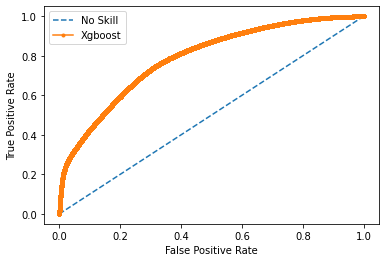

In [42]:
ns_probs = [0 for _ in y_valid]

ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lr_fpr, lr_tpr, thres = roc_curve(y_valid, pred_proba)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Xgboost')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

In [43]:
AUC = roc_auc_score(y_valid, pred_proba)
print('AUC: {:.4f}'.format(AUC))

AUC: 0.7880


## 2) 평가지표 확인
- threshold 값 : 0.5
- 오차행렬(confusion matrix) 생성
- 정확도, 정밀도, 재현율, F1 Score, AUC 값 산출

In [44]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred); print('오차행렬:\n', confusion)
    accuracy = accuracy_score(y_test, y_pred); print('\n정확도: {:.4f}'.format(accuracy))
    precision = precision_score(y_test, y_pred); print('정밀도: {:.4f}'.format(precision))
    recall = recall_score(y_test, y_pred); print('재현율: {:.4f}'.format(recall))
    F1 = f1_score(y_test, y_pred); print('F1: {:.4f}'.format(F1))

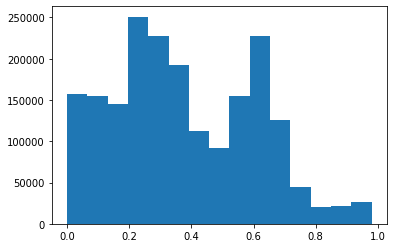

In [45]:
plt.hist(pred_proba, bins = 15)
plt.show()

In [46]:
preds = [ 1 if x > 0.5 else 0 for x in pred_proba]
get_clf_eval(y_valid, preds)

오차행렬:
 [[1281114  599513]
 [  18213   54256]]

정확도: 0.6837
정밀도: 0.0830
재현율: 0.7487
F1: 0.1494


## 3) 변수중요도 그림 (Importance Plot)

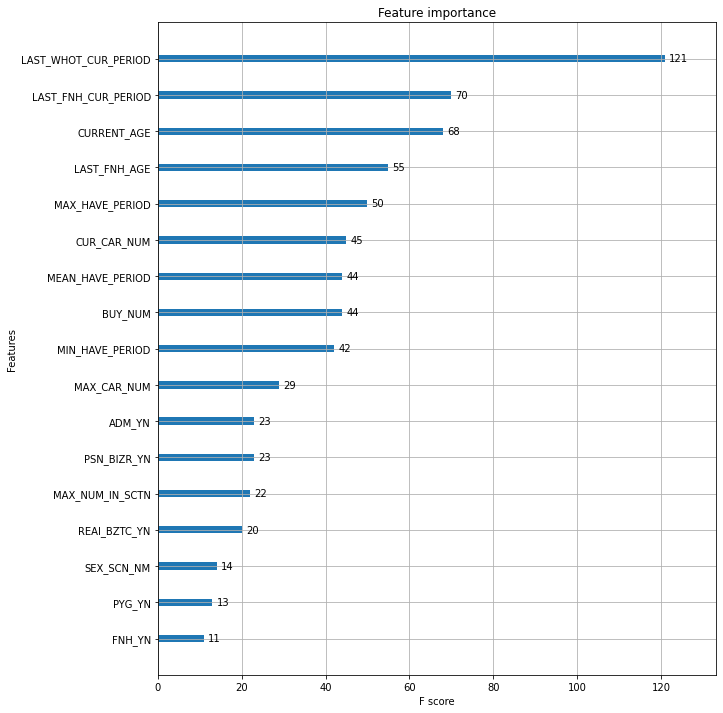

In [47]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)
plt.show()